In [1]:
import random
import sys

import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
from sklearn.decomposition import PCA

from config import Config
from data import *
from models import *
from train import *
from run import setup_seed

sys.path.insert(0, "./src")

In [2]:
setup_seed(12)

In [3]:
DATA_PATH = "./data/PSI_Biology_solubility_trainset.csv"
SAVE_MODEL_DIR = "./models/"
SAVE_MODEL_PREFIX = "cnn_"
LOAD_MODEL_PATH = None  # E.g. "./models/cnn_1"

In [4]:
config = Config.params

model_conf = {
    "cnn": [
        # in_channels, out_channels, kernel_size, dropout_p
        [20, 8, 3, 0.2],
        [8, 4, 3, 0.2],
        [4, 2, 3, 0.2],
    ],
    "linear": [
        # in_features, #out_features, dropout_p
        [config["max_chain_length"] * 2, config["max_chain_length"], 0.2],
    ],
}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
data = init_data(DATA_PATH, device, config["max_chain_length"])

In [7]:
model = Model1(model_conf)
model.to(device)

Model1(
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(20, 8, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(4, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1572, out_features=786, bias=True)
      (bn): BatchNorm1d(786, eps=1e-0

In [8]:
# Load pretrained weights
if LOAD_MODEL_PATH != None:
    model.load_state_dict(torch.load(LOAD_MODEL_PATH))

In [9]:
optimiser = torch.optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"],
)

In [10]:
criterion = nn.BCEWithLogitsLoss(pos_weight=data["neg_pos_ratio"]).to(device)

In [11]:
# Training
for e in range(1, 101):
    train_epoch(data, model, optimiser, criterion, config["batch_size"])

    # Evaluation
    if e % config["eval_step"] == 0:
        eval_model(e, data, model, optimiser, criterion)

        model.train()
        torch.save(model.state_dict(), SAVE_MODEL_DIR + SAVE_MODEL_PREFIX + str(e))

Epoch 10 - Train loss: 0.362; Test loss: 0.514
Accuracy: 0.670
Precision: 0.835
Recall: 0.710
Pred. STD: 0.225
F1: 0.772
ROC AUC: 0.673
Epoch 20 - Train loss: 0.195; Test loss: 0.587
Accuracy: 0.660
Precision: 0.771
Recall: 0.731
Pred. STD: 0.306
F1: 0.749
ROC AUC: 0.664
Epoch 30 - Train loss: 0.127; Test loss: 0.739
Accuracy: 0.656
Precision: 0.775
Recall: 0.727
Pred. STD: 0.341
F1: 0.747
ROC AUC: 0.647
Epoch 40 - Train loss: 0.091; Test loss: 0.874
Accuracy: 0.657
Precision: 0.782
Recall: 0.725
Pred. STD: 0.351
F1: 0.749
ROC AUC: 0.638
Epoch 50 - Train loss: 0.073; Test loss: 0.972
Accuracy: 0.664
Precision: 0.791
Recall: 0.725
Pred. STD: 0.355
F1: 0.758
ROC AUC: 0.644
Epoch 60 - Train loss: 0.063; Test loss: 1.039
Accuracy: 0.658
Precision: 0.791
Recall: 0.721
Pred. STD: 0.368
F1: 0.752
ROC AUC: 0.643
Epoch 70 - Train loss: 0.071; Test loss: 1.298
Accuracy: 0.671
Precision: 0.835
Recall: 0.711
Pred. STD: 0.343
F1: 0.773
ROC AUC: 0.617
Epoch 80 - Train loss: 0.053; Test loss: 1.253
A

In [28]:
model.eval()

Model1(
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(20, 8, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(4, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1572, out_features=786, bias=True)
      (bn): BatchNorm1d(786, eps=1e-0

In [65]:
# test_seq = torch.tensor(range(1, 21)).reshape(1, -1).to(device)
test_seq = torch.randint(1, 21, (1, 100)).to(device)

In [66]:
test_oh = encode_one_hot(test_seq)

In [67]:
output = model.cnn[0].conv(test_oh).reshape(8, -1).cpu().detach().numpy()

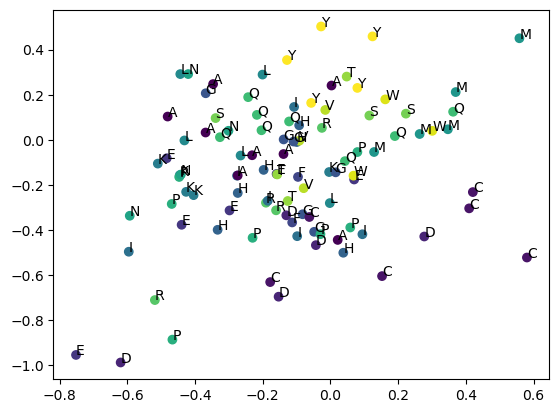

In [76]:
plt.scatter(output[2, :], output[5, :], c=test_seq[0].cpu().detach())
for (i, n) in enumerate(test_seq[0]):
    plt.annotate(residues[n - 1], (output[2, i], output[5, i]))

In [68]:
X = np.transpose(output)

In [69]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [70]:
X_red = numpy.transpose(pca.transform(X))

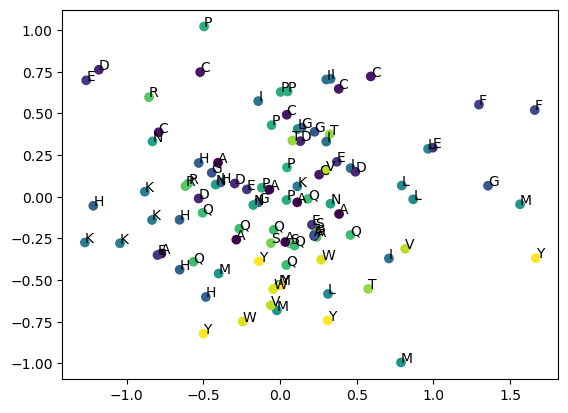

In [71]:
plt.scatter(X_red[0, :], X_red[1, :], c=test_seq[0].cpu().detach())
for (i, n) in enumerate(test_seq[0]):
    plt.annotate(residues[n - 1], (X_red[0, i], X_red[1, i]))